# 3 лаба. Используем тут адаптивный парог

## тут создаем небольшие утилиты

In [302]:
%pylab inline

from math import exp
import math

def F_threshold_binary(s):
    y = 0 if s <=0 else 1
    return y

def F_threshold_bipolar(s):
    y = -1 if s<=0 else 1
    return y

def F_sigmoidal_binory(s, param = 1):
    e = 0
    if (s < -600 ) :
        e = 9999999999
    else :
        e = exp(-param * s)
    y = 1 / (1+(e))
    return y
    
def F_sigmidal_bipolar(s, param = 1):
    y = (2 / (1+(exp(-param * s)))) - 1;
    return y

def F_hiperbolic_tg(s):
    return F_sigmidal_bipolar(s, 2)

def F_linear(s):
    return s

def step_constant_small(_):
    return 0.01

def step_constant_medium(_):
    return 0.1

def step_constant_large(_):
    return 0.5

def step_adaptive(x):
    s = sum(xi**2 for xi in x)
    return 1.0 / (1 + s)

#import math
import matplotlib.pyplot as plt
from random import random, shuffle

def generate_sin_dots(a, b, c, size, step):    
    points = []
    t = 0
    for i in range(size):
        t = t + step
        y = a * math.sin(b * t) + c;
        points.append((t, y))
        
    return points

def generate_complex_func_dots(a, b, c, d, size, step):    
    points = []
    t = 0
    for i in range(size):
        t = t + step
        y = a * math.cos(b * t) + c*math.sin(d * t);
        points.append((t, y))
        
    return points

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## тут определяем нейронную сеть

In [303]:
class perceptrone:
    def __init__(self, inCount):
        self.in_count = inCount
        self.w = []
        self.T = 1;
        self.alf = 0.01
            
    def teach(self, inputs, outputs, Ee):
        self.w = [0.1 for x in range(self.in_count)]
        cur_epoch = 0
        good_epoch = False
        prevE = -1
        while(not good_epoch):
            j = 0
            for cur_input in inputs:
                self.alf = step_adaptive(cur_input)
                S = 0
                i = 0
                for xi in cur_input:
                    S = S + xi*self.w[i]
                    i = i + 1;
                S = S - self.T
                y = F_linear(S)
                K = y - outputs[j]
                i = 0
                for wi in self.w:
                    wi = wi - (self.alf * cur_input[i] * K)
                    self.w[i] = wi
                    i = i + 1;
                self.T = self.T + (self.alf * K)
                j = j + 1
            Es = 0
            j = 0
            for cur_input in inputs:
                S = 0
                i = 0
                for xi in cur_input:
                    S = S + xi*self.w[i]
                    i = i + 1;
                S = S - self.T
                y = F_linear(S)
                Es = Es + (y - outputs[j])**2
            Es = Es / 2
            if (prevE != -1) and (abs(prevE - Es) < Ee):
                good_epoch = True
            prevE = Es
            cur_epoch = cur_epoch + 1
            #if (good_epoch):
            #    break
#             if (cur_epoch > 200):
#                 break
        
    def get_prophecy(self, sample):
        i = 0
        S = 0
        for xi in sample:
            S = S + xi*self.w[i]
            i = i + 1;
        S = S - self.T
        y = F_linear(S)
        return y

In [304]:
class two_layer_perceptrone :
    def __init__(self, in_count, interm_count) :
        self.in_count = in_count
        self.interm_count = interm_count
        self.T_interm = [];
        for i in range(interm_count) :
            self.T_interm.append(0.1)
        self.T_out = 0.5;
        self.w_interm = []
        
    def get_prophecy(self, sample):
        # forward interm layer
        y = []
        for j in range(self.interm_count) :
            S = 0
            i = 0
            for xi in sample:
                S = S + xi*self.w_interm[i][j]
                i = i + 1;
            S = S - self.T_interm[j]
            y.append(F_sigmoidal_binory(S))

        #forward out layer
        S = 0
        i = 0
        for yi in y:
            S = S + yi*self.w_out[i]
            i = i + 1;
        S = S - self.T_out
        Y = F_linear(S)

        return Y
    
    def teach(self, inputs, outputs, Ee) :
        for i in range(self.in_count) :
            wi = [0.1 for x in range(self.interm_count)]
            self.w_interm.append(wi)
            
            
        self.w_out = [0.1 for x in range(self.interm_count)]
        
        
        cur_epoch = 0
        good_epoch = False
        prevE = -1
        while(not good_epoch):
        
            sample_index = 0
            for cur_input in inputs:
                y = []

                # forward interm layer
                for j in range(self.interm_count) :
                    S = 0
                    i = 0
                    for xi in cur_input:
                        S = S + xi*self.w_interm[i][j]
                        i = i + 1;
                    S = S - self.T_interm[j]
                    y.append(F_sigmoidal_binory(S))

                #forward out layer
                S = 0
                i = 0
                for yi in y:
                    S = S + yi*self.w_out[i]
                    i = i + 1;
                S = S - self.T_out
                Y = F_linear(S)

                #count out layer E
                E_out = Y - outputs[sample_index]

                #count interm layer E
                E_interm = []
                for i in range(self.interm_count):
                    E_interm.append(self.w_out[i] * E_out)

                #count in_layer E
    #             E_in = []
    #             for i in range(self.in_count):
    #                 E_in[i].append(0)
    #                 for j in range(self.interm_count):
    #                     E_in[i] = E_in[i] + E_interm[j]*self.w_interm[i][j]*(2 * (1 - y[j]) * y[j])

        
                #count adaptive alphas
                alf_interm = step_adaptive(cur_input)
                alf_out = step_adaptive(y)
                
                # count new weights for interm layer
                for j in range(self.interm_count) :
                    for i in range(self.in_count) :
                        self.w_interm[i][j] = self.w_interm[i][j] - alf_interm* \
                        (E_interm[j]) * ((1 - y[j]) * y[j]) * cur_input[i]

                    self.T_interm[j] = self.T_interm[j] + alf_interm * \
                    (E_interm[j]) * ((1 - y[j]) * y[j])

                    #count new weights for out layer
                    self.w_out[j] = self.w_out[j] - alf_out * (E_out) * y[j]
                #count new weight for out thershold
                self.T_out = self.T_out + alf_out * (E_out)

                sample_index = sample_index + 1
            
            # count Es
            Es = 0
            j = 0
            for cur_input in inputs:
                ans = self.get_prophecy(cur_input)
                Es = Es + (ans - outputs[j])**2
                j = j + 1
            Es = Es / 2
            print Es
            if (prevE != -1) and (Es < Ee) and (cur_epoch > 3):
                print cur_epoch
                good_epoch = True
                
#             if (cur_epoch > -1) :
#                 print cur_epoch
#                 return
                
            prevE = Es
            cur_epoch = cur_epoch + 1
            

## тут решаем задачу используя определенную выше сеть

0.802593650871
0.802939140155
0.803310822454
0.803706116908
0.8041224864
0.804557457861
0.805008638327
0.805473727293
0.805950525886
0.806436943306
0.806931000959
0.807430834655
0.807934695185
0.808440947573
0.808948069247
0.80945464734
0.809959375312
0.810461049044
0.810958562535
0.811450903327
0.81193714774
0.812416456001
0.812888067331
0.813351295046
0.813805521712
0.814250194384
0.814684819973
0.81510896074
0.815522229948
0.815924287672
0.81631483679
0.816693619133
0.817060411829
0.817415023803
0.817757292467
0.818087080563
0.818404273179
0.818708774918
0.819000507217
0.819279405806
0.819545418307
0.819798501953
0.820038621433
0.820265746835
0.820479851704
0.820680911179
0.820868900225
0.821043791937
0.821205555904
0.821354156647
0.821489552094
0.821611692104
0.821720517026
0.821815956284
0.821897926975
0.821966332491
0.82202106113
0.822061984705
0.822088957151
0.822101813093
0.822100366399
0.822084408685
0.822053707783
0.822008006144
0.821947019184
0.821870433555
0.821777905327
0.

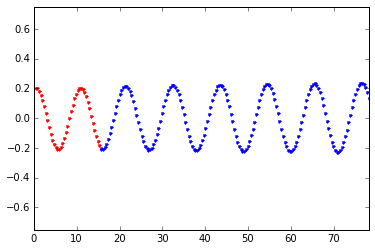

In [305]:
def solve_problem(lenght, steps_count, window_size):
    step_length = lenght / steps_count
    #p = generate_sin_dots(1, 5, 0, steps_count, step_length);
    
    a = 0.2
    b = 0.6
    c = 0.05
    d = 0.6
    
    
    p = generate_complex_func_dots(a, b, c, d, steps_count, step_length)
    longp = p
    p = p[0: len(p) / 2]
    new_steps_count = len(p)
    p = zip(*p)
    sample_size = new_steps_count - window_size
    sample = []
    answers = []
    for i in range(0, sample_size) :
        sample.append(p[1][i : i + window_size])
        answers.append(p[1][i + window_size])
    prc = two_layer_perceptrone(len(sample[0]), 4)
    prc.teach(sample, answers, 0.001)
    print prc.w_interm
    print prc.w_out
    plt.plot(p[0], p[1], 'r.')
    newdots = list(p[1][len(list(p[1])) - window_size : len(list(p[1]))])
    #newdots = list(p[1][0 : window_size])
    print "window size: ", window_size
    x = 0.0
    for i in range(0, steps_count * 2):
        x = 0.0 + (len(p[1]) + i)*step_length
        #x = (i + window_size)*step_length
        y = prc.get_prophecy(newdots[len(newdots) - window_size: len(newdots)])
        plt.plot(x, y, 'b.')
        newdots.append(y)
        
    #print newdots
        

    maxvalue = abs(a)+abs(c)
    plt.axis([0, x, -maxvalue*3, maxvalue*3])
    
    plt.show()
     
solve_problem(10*math.pi, 80, 10)